# SKU Segmentation using Sales Analytics Mart

This notebook performs SKU-level segmentation using aggregated sales metrics
derived from a SKU analytics mart. The goal is to identify distinct groups of
products based on their sales behavior across Amazon and International channels,
and translate those patterns into actionable business insights.


## Objective

- Group SKUs with similar sales behavior using unsupervised learning
- Identify high-performing, low-performing, and channel-dependent SKU segments
- Support inventory planning, channel strategy, and product prioritization

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [10]:
df = pd.read_csv("E:/sku_analytics_mart.csv")

In [11]:
df.head()

,product_id,sku,design_no,category,size,color,intl_units_sold,intl_revenue,intl_avg_price,amazon_units_sold,amazon_revenue,amazon_avg_price
0,1,J0289-KR-L,J0289,Kurta,L,Black,NaN,NaN,NaN,NaN,NaN,NaN
1,2,JNE3796-KR-XXL,JNE3796,Kurta,XXL,Peach,NaN,NaN,NaN,3.0,1363.57,345.000000
2,3,J0117-TP-M,J0117,Top,M,White,44719.0,461.0,426.095000,90.0,57745.15,590.311111
3,4,AN210-NAVY-L,AN210,An : Leggings,L,Navy Blue,NaN,NaN,NaN,NaN,NaN,NaN
4,5,SET269-KR-NP-XXL,SET269,Set,XXL,Green,581975.0,6108.0,968.979167,35.0,29261.71,791.885714


In [12]:
df["sold_intl"] = df["intl_units_sold"].fillna(0) > 0
df["sold_amazon"] = df["amazon_units_sold"].fillna(0) > 0
df["sold_anywhere"] = df["sold_intl"] | df["sold_amazon"]

In [13]:
df_ml = df[df["sold_anywhere"]].copy()

In [14]:
sales_zero_cols = [
    "intl_units_sold", "intl_revenue",
    "amazon_units_sold", "amazon_revenue"
]

df_ml[sales_zero_cols] = df_ml[sales_zero_cols].fillna(0)

df_ml["amazon_avg_price_f"] = df_ml["amazon_avg_price"].fillna(0)
df_ml["intl_avg_price_f"] = df_ml["intl_avg_price"].fillna(0)

In [15]:
df_ml.shape

(7393, 17)

In [16]:
df_ml["sold_anywhere"].value_counts()

sold_anywhere
True    7393
Name: count, dtype: int64

In [17]:
# Fill structural nulls for sales metrics
sales_zero_cols = ["intl_units_sold","intl_revenue","amazon_units_sold","amazon_revenue"]
df_ml[sales_zero_cols] = df_ml[sales_zero_cols].fillna(0)

# Keep avg prices as NaN; create safe numeric versions
df_ml["amazon_avg_price_f"] = df_ml["amazon_avg_price"].fillna(0)
df_ml["intl_avg_price_f"] = df_ml["intl_avg_price"].fillna(0)

# Log-transform heavy-tailed metrics (important for clustering stability)
for c in ["intl_units_sold","intl_revenue","amazon_units_sold","amazon_revenue"]:
    df_ml[f"log_{c}"] = np.log1p(df_ml[c])
# Features were selected to capture volume, revenue, and pricing behavior across channels.

features = [
    "log_amazon_units_sold",
    "log_amazon_revenue",
    "log_intl_units_sold",
    "log_intl_revenue",
    "amazon_avg_price_f",
    "intl_avg_price_f"
]

X = df_ml[features]
X.head()

,log_amazon_units_sold,log_amazon_revenue,log_intl_units_sold,log_intl_revenue,amazon_avg_price_f,intl_avg_price_f
1,1.386294,7.218595,0.000000,0.000000,345.000000,0.000000
2,4.510860,10.963812,10.708176,6.135565,590.311111,426.095000
4,3.583519,10.284069,13.274184,8.717518,791.885714,968.979167
5,0.000000,0.000000,10.499601,5.866468,0.000000,356.500000
6,4.343805,11.120875,0.000000,0.000000,889.026316,0.000000


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Modeling Approach

- The analysis uses **KMeans clustering**, an unsupervised learning algorithm,
  to segment SKUs based on sales behavior.
- Input features are aggregated, SKU-level metrics from Amazon and International
  channels.
- Highly skewed sales variables are log-transformed to reduce the influence of
  extreme values.
- All features are standardized prior to clustering to ensure equal contribution
  to distance calculations.


In [19]:
from sklearn.cluster import KMeans

inertia = []
ks = range(2, 9)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_scaled)
    inertia.append(km.inertia_)

list(zip(ks, inertia))

[(2, 24646.568302328953),
 (3, 14141.273297090525),
 (4, 11088.294068399971),
 (5, 9071.786142461911),
 (6, 7260.8881383431935),
 (7, 6246.370562714324),
 (8, 5622.730779439289)]

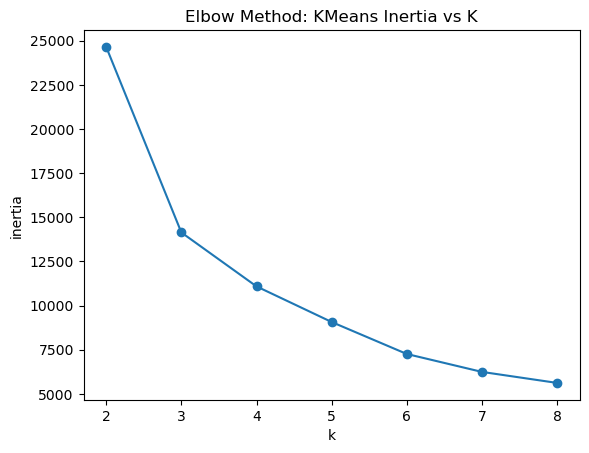

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(list(ks), inertia, marker="o")
plt.title("Elbow Method: KMeans Inertia vs K")
plt.xlabel("k")
plt.ylabel("inertia")
plt.show()

## Choosing the Number of Clusters

The elbow method was used to evaluate KMeans inertia across values of K from 2 to 8.
A clear reduction in inertia is observed up to K = 3, after which improvements
become marginal.

Based on this trade-off between model simplicity and explanatory power,
K = 3 was selected as the final number of clusters.

In [21]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
df_ml["cluster"] = kmeans.fit_predict(X_scaled)

df_ml["cluster"].value_counts()

cluster
2    3655
0    2888
1     850
Name: count, dtype: int64

## Cluster Interpretation

The clustering results reveal three distinct SKU segments with clearly different
sales behaviors across channels.


In [22]:
cluster_profile = df_ml.groupby("cluster")[[
    "amazon_units_sold","amazon_revenue","amazon_avg_price",
    "intl_units_sold","intl_revenue","intl_avg_price"
]].mean().round(2)

cluster_profile

,amazon_units_sold,amazon_revenue,amazon_avg_price,intl_units_sold,intl_revenue,intl_avg_price
cluster,,,,,,
0,13.17,8963.46,616.01,0.00,0.00,NaN
1,0.04,10.29,55.72,197066.08,2517.69,668.12
2,19.61,13288.68,608.92,270609.44,3389.27,788.18


In [23]:
cluster_sizes = df_ml["cluster"].value_counts().sort_index()
cluster_sizes

cluster
0    2888
1     850
2    3655
Name: count, dtype: int64

### Cluster 0 — Amazon-Only Moderate Performers
- Represents ~39% of SKUs
- Moderate Amazon sales and revenue
- No recorded international sales

These SKUs are primarily Amazon-dependent and may benefit from channel-specific
optimization such as listing quality improvements, promotions, or targeted ads.

---

### Cluster 1 — International-Heavy SKUs with Minimal Amazon Presence
- Represents ~11% of SKUs
- Extremely high international unit sales
- Negligible Amazon activity

This cluster highlights SKUs with strong international demand but little or no
Amazon penetration. These products present strategic decisions:
either expand Amazon presence or intentionally focus on international channels.

---

### Cluster 2 — High-Performing Cross-Channel SKUs
- Represents ~50% of SKUs
- Strong performance across both Amazon and International channels
- Highest average units sold, revenue, and pricing

These SKUs are the core revenue drivers of the business and should be prioritized
for inventory availability, marketing spend, and supply-chain reliability.

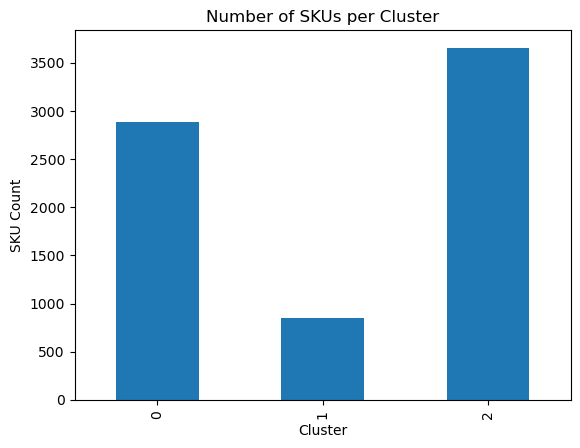

In [24]:
cluster_sizes.plot(kind="bar")
plt.title("Number of SKUs per Cluster")
plt.xlabel("Cluster")
plt.ylabel("SKU Count")
plt.show()

The cluster size distribution shows that high-performing cross-channel SKUs
form the largest segment, while international-heavy SKUs represent a smaller,
but strategically important, group.

## Summary and Business Implications

This analysis demonstrates that SKU-level sales behavior can be effectively
segmented using aggregated channel metrics.

Key takeaways:
- SKU demand is not uniform and naturally clusters into distinct behavioral groups
- Channel dependency is a major differentiator in product performance
- Cross-channel SKUs consistently outperform single-channel SKUs
- International-heavy SKUs represent untapped or intentionally specialized segments
- Segmentation provides a practical framework for inventory planning, channel
  expansion, and product prioritization

This clustering exercise does not attempt to predict demand. Instead, it provides
a descriptive, data-driven view of SKU performance that can inform strategic and
operational decisions.

Future work could extend this analysis by incorporating time-based features,
price elasticity, or promotional data.